In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append('..')
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import IPython.display as ipd
import matplotlib.pyplot as plt
from kyber import Kyber512 #you should also try Kyber768 and Kyber 1024
import os
import time
import numpy as np

Error importing AES CTR DRBG. Have you tried installing requirements?
ImportError: No module named 'Crypto'

Kyber will work perfectly fine with system randomness


In [3]:
# Sample rate chosen to read audio
sample_rate = 8000

# Minimum duration of audio files to consider
min_duration = 1.0

# Our training data will be frame of slightly above 1 second
frame_length = 8064

# hop length for clean voice files separation (no overlap)
hop_length_frame = 8064

# Choosing n_fft and hop_length_fft to have squared spectrograms
n_fft = 255
hop_length_fft = 63

dim_square_spec = int(n_fft / 2) + 1


validation_folder_ex = './validation'

# Vaccum signal example

In [8]:
list_files = ['noisy_voice_vaccum35.wav','voice_pred_vaccum35.wav','voice_vaccum35.wav']

### Voice

In [15]:
voice_vaccum, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
ipd.Audio(voice_vaccum, rate=8000)

## Kyber - Signal

Ciphertext:  b'\x1b\x19_n\x9bo\x96Q\xf3\xbd7\xdb/\xa9\xf4\xa6\xb9\xc8\xf8E~A>\xb4\xf9]\x94\x15\xf4\xb2-7c\x04<%\xc4W_\xbf\xe1T\xb8Q\x13\xf5\x7f\xb7(\x84Eq\xa4\x19\xf6\xe4\x12\xe42oY\x93]n\x93\xfd0\xc9Y\x88\x80\x87+\x98\xf5\x1f\xb0\x87\xe4\xf7`\xc9\rbx\x99\x90\x92\x9f\x0c\x08\x0f@\x82y\xba\xe6\xe6\xeaY\xd9z\x1f\x009r\xab\xd7NOq \x06^\xecI+/\xd6\xbb\x89[a\xd1\x06kgX\xa0\x00;\xe7b\xd0G\xddj\x1b\nx\x13\xda\xf0\xefO\xc0\xd5\xa2\xdf\xfb\x08\xdd\xc2\xa1\x08_\x87 \xde?4=y\xe9\x8c@Y\xf0\x04\xee\xaa\xe0\x89\x9c9\xa8a\x18wp@X\x982`a\xc4\n\xbb\xddR\xc3@\xfa\xf5\xca\x04\x04\xd2B\x92\xfcK\xae?@%c\xf3\xceQk\x0f\x8en\xc1\xae\xae\x06\x90D\xd1\xb8\xaf>\x11\x18N\xbdI\xe8\x04\xd7G\x0e!\x1c\x0247o\xb4\xf4\xacM\xc8\xd9\xfc\xf4\xd9\xd0\x83\xfcK\xa5\xc3\xed\x8e\x9b\x81\x8eb\x90\xf0\xd2Q\xb9\xd1\xa0\xcf\x8d\xcd\xfb\x138)\\\x08\xf1\n\xf2\xdd\xf6\xd1@LU\xea+\x83\x8c\xc9R7\xc2\x97\x96qu\xd5\xcc\x18\x91\xd7 Dr\x99\xfe\x88-\x9fN"oc\xe6~\xeb~\x8f\xc9\x03\x98H\x97]\xeb\x12o\x15\xea\x98\xe3Z\xd8\x95Hj\xd9tM\xe0\x83\n\

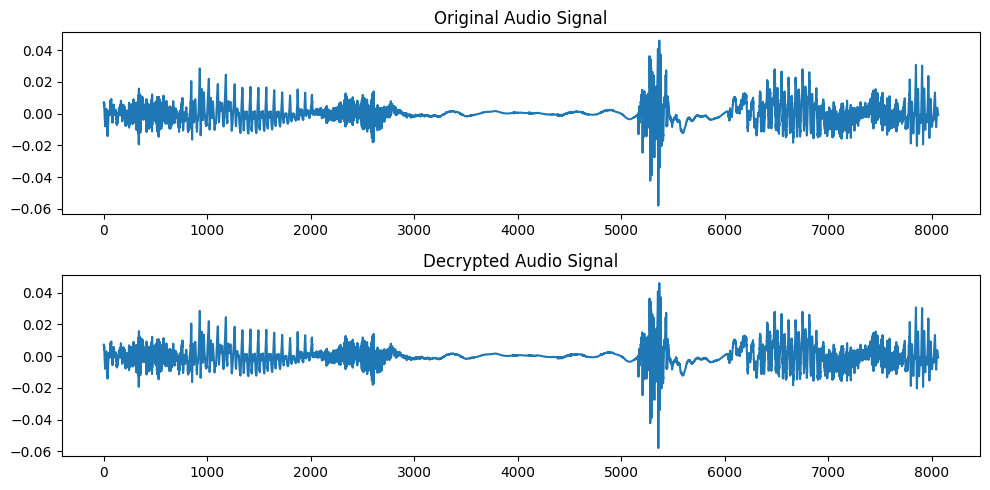

Decryption successful


In [16]:
# Step 1: Load your audio data as a NumPy array
audio_data = np.array(voice_vaccum, dtype=np.float32)

# Plot the original audio signal
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title("Original Audio Signal")
plt.plot(audio_data)

# Step 2: Generate a key pair
public_key, secret_key = Kyber512.keygen()

# Step 3: Define the chunk size (adjust as needed)
chunk_size = 8

# Step 4: Encrypt and decrypt audio data in chunks
ciphertexts = []
decrypted_chunks = []

# Measure encryption time
encryption_start_time = time.time()

for i in range(0, len(audio_data), chunk_size):
    # Extract a chunk of audio data
    chunk = audio_data[i:i+chunk_size]

    # Convert the chunk to bytes
    chunk_bytes = chunk.tobytes()
    
    remainder = len(chunk_bytes) % 32
    if remainder != 0:
        # Pad the audio data with zeros to make it a multiple of 32 bytes
        padding_length = 32 - remainder
        chunk_bytes += b'\x00' * padding_length

    # Encrypt the chunk with the public key
    ciphertext = Kyber512._cpapke_enc(public_key, chunk_bytes, coins=os.urandom(32))
    ciphertexts.append(ciphertext)

# print(f"Ciphertext: ",ciphertext)

# Measure encryption time
encryption_end_time = time.time()

# Measure decryption time
decryption_start_time = time.time()

for ciphertext in ciphertexts:
    # Decrypt the ciphertext with the secret key
    decrypted_chunk_bytes = Kyber512._cpapke_dec(secret_key, ciphertext)
    
    # Step 6: Remove any padding to obtain the decrypted audio data
    decrypted_chunk_bytes = decrypted_chunk_bytes[:len(chunk_bytes)]

    # Convert the decrypted bytes back to a NumPy array
    decrypted_chunk = np.frombuffer(decrypted_chunk_bytes, dtype=np.float32)

    # Append the decrypted chunk to the list of decrypted chunks
    decrypted_chunks.append(decrypted_chunk)

# Measure decryption time
decryption_end_time = time.time()

# Calculate the elapsed times
encryption_elapsed_time = encryption_end_time - encryption_start_time
decryption_elapsed_time = decryption_end_time - decryption_start_time

print(f"Encryption time: {encryption_elapsed_time} seconds")
print(f"Decryption time: {decryption_elapsed_time} seconds")

# Combine the decrypted chunks into the final decrypted audio data
decrypted_audio_data = np.concatenate(decrypted_chunks)
decrypted_audio_data = decrypted_audio_data[:len(audio_data)]

# Plot the decrypted audio signal
plt.subplot(2, 1, 2)
plt.title("Decrypted Audio Signal")
plt.plot(decrypted_audio_data)

# Show the plots
plt.tight_layout()
plt.show()

# Verify that the decrypted audio data matches the original
if np.array_equal(audio_data, decrypted_audio_data):
    print("Decryption successful")
else:
    print("Decryption failed or audio data mismatch.")
